In [259]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [260]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [263]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.mu = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        self.rho = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu).double()
            
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma).double()
        
        rho = torch.log(torch.exp(sigma) - 1)
        
        nn.init.constant_(self.mu, mu)
        nn.init.constant_(self.rho, rho)
        
    def set_mu(self, mu):
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu)
        nn.init.constant_(self.mu, mu)
        
        
    def set_rho(self, rho):
        if not torch.is_tensor(rho):
            rho = torch.tensor(rho)
        nn.init.constant_(self.rho, rho)
       
    def set_sigma(self, sigma):
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma)
        rho = self._sigma_to_rho(sigma)
        self.set_rho(rho)
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def sample(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return epsilon.mul(sigma).add(self.mu)
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    def _sigma_to_rho(self, sigma):
        rho = torch.log(torch.exp(sigma) - 1)
        return rho
    
    def log_prob(self, z):
        S = torch.diag(self.sigma)
        return torch.distributions.multivariate_normal.MultivariateNormal(self.mu, scale_tril=S).log_prob(z).unsqueeze(-1)

# Variational Distribution #

In [265]:
q = MeanFieldVariationalDistribution(nb_dim=1)

In [268]:
x = torch.arange(-10, 10.0, 0.01)

torch.float32

In [272]:
q.mu.detach().numpy()

array([0.], dtype=float32)

In [269]:
%matplotlib notebook
x = torch.arange(-10, 10.0, 0.01)
plt.plot(x, torch.distributions.normal.Normal(q.mu.detach().numpy(), q.sigma.detach().numpy()).log_proba(x))
plt.show()

ValueError: Input arguments must all be instances of numbers.Number or torch.tensor.

# Prior #

In [249]:
prior_mu = 0.0
prior_sigma = 3.0

In [250]:
def prior(x):
    return torch.exp(torch.distributions.normal.Normal(prior_mu, prior_sigma).log_prob(x))

def logprior(x):
    return torch.distributions.normal.Normal(prior_mu, prior_sigma).log_prob(x)

# Likelihood #

In [251]:
def likelihood(x):
    norm_params = np.array([[-3, 1],
                            [-6, 0.3],
                            [-8, 0.5]])
    weights = torch.ones(3)/3

    ys = torch.zeros(x.shape).double()
    for (l, s), w in zip(norm_params, weights):
        ys += torch.exp(torch.distributions.normal.Normal(loc=l, scale=s).log_prob(x)) * w
    return ys

def loglikelihood(x):
    return torch.log(likelihood(x))

# Posterior #

In [252]:
def posterior(x):
    return prior(x)*likelihood(x)

In [253]:
def logposterior(x):
    return logprior(x) + loglikelihood(x)

<IPython.core.display.Javascript object>


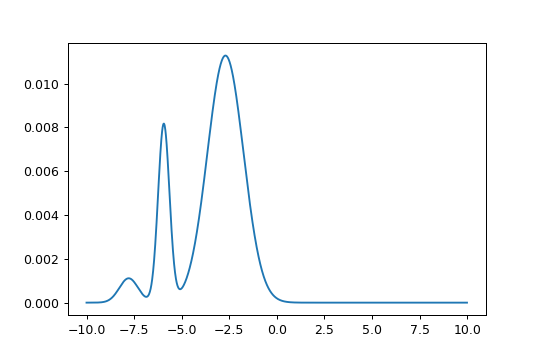

In [254]:
%matplotlib notebook
%matplotlib notebook

x = torch.tensor(np.arange(-10, 10.0, 0.01))
#plt.plot(x, prior(x))
#plt.plot(x, likelihood(x))
plt.plot(x.detach().cpu().numpy(), posterior(x).detach().cpu().numpy())
plt.show()

In [255]:
q = MeanFieldVariationalDistribution(1)

In [256]:
n_samples_ELBO = 1

In [258]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

ValueError: optimizer got an empty parameter list

In [244]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logprior(z)
    LL = loglikelihood(z)
    L = (LQ - LP - LL).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        if n_samples_ELBO > 1000:
            break
        else:
            optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)
            n_samples_ELBO = n_samples_ELBO*10
        

RuntimeError: expected backend CPU and dtype Double but got backend CPU and dtype Float

In [245]:
z.dtype

torch.float32

<IPython.core.display.Javascript object>


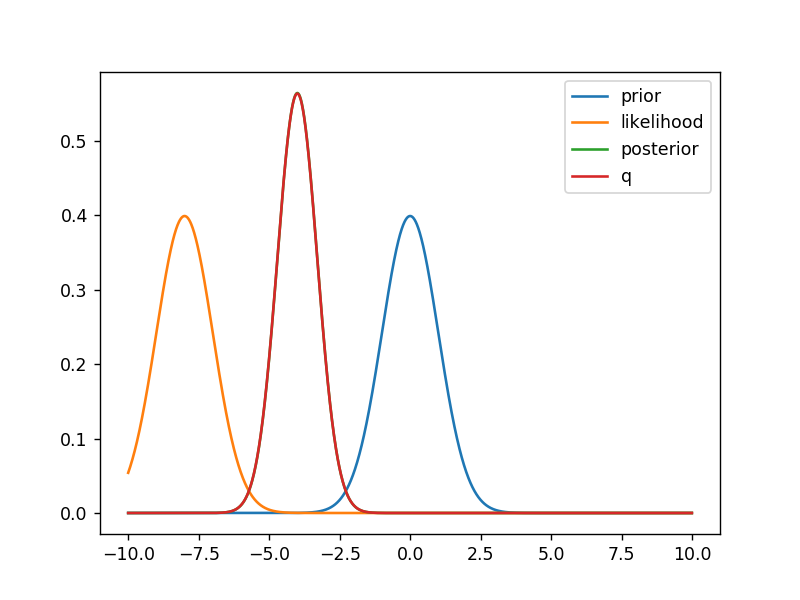

In [77]:
%matplotlib notebook
%matplotlib notebook

x = np.arange(-10, 10.0, 0.01)
plt.plot(x, prior(x))
plt.plot(x, likelihood(x))
plt.plot(x, posterior(x))
plt.plot(x, stats.norm.pdf(x, q.mu.detach().numpy(), q.sigma.detach().numpy()))
plt.legend(['prior', 'likelihood', 'posterior', 'q'])
plt.show()

In [170]:
n_samples_ELBO = 10
z = q.sample(n_samples_ELBO)
LQ = q.log_prob(z)
LP = logprior(z)
LL = loglikelihood(z)
L = (LQ - LP - LL).sum()/n_samples_ELBO
L

tensor(6909.7329, grad_fn=<DivBackward0>)